# Titanic Survival

Titanic EDA, visualizations, with SkLearn Pipelines for feature engineering, training - evaluation, and inference.

## Challenge Description

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Data Dictionary

|**Variable**|**Definition**|**Values**|**Null Count**|
|-|-|-|-|
|PassengerId|Integer - unique id|892-1309|0|
|Survived|Integer - target|0=No, 1=Yes|0|
|Pclass|Integer - ticket class|1=1st, 2=2nd, 3=3rd|0|
|Name|String - passenger name|418 unique values|0|
|Sex|String - passenger sex|male 64%, female, 36%|0|
|Age|Float - passenger age|0.17 - 76|177|
|SibSp|Integer - # of siblings/spouses aboard|0-8|0|
|Parch|Integer - # of parents/children aboard|0-9|0|
|Ticket|String - ticket number|409 unique values|0|
|Fare|Float - price of ticket|0 - 512|0|
|Cabin|String - cabin number|89 unique values|687|
|Embarked|Enum - port of embarkation|C=Cherbourg, Q=Queenstown, S=Southampton|2|


**Train Record Count:** 891

**Test Record Count:** 418

**Variable Notes**

**pclass:** A proxy for socio-economic status (SES)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

**Age:** 
    * Age is fractional if less than 1
    * If the age is estimated, is it in the form of xx.5

**sibsp:** 
The dataset defines family relations in this way:
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** 
The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.

### Imports and Environment Settings

In [268]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import pickle
import io
import re

from sagemaker import get_execution_role
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, KFold
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from io import StringIO

role = get_execution_role()
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 10
pd.options.display.max_columns = 20

print("numpy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("seaborn version: {}\n".format(sns.__version__))

sns.set_style("whitegrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)

numpy version: 1.18.1
pandas version: 1.0.3
seaborn version: 0.10.0



## Load the Data

In [269]:
# Read the CSV
BUCKET = 'bf-titanic-data'
MODEL_BUCKET = 'bf-titanic-model'

train_key = 'train.csv'
test_key = 'test.csv'
train_path = 's3://{}/{}'.format(BUCKET, train_key)
test_path = 's3://{}/{}'.format(BUCKET, test_key)

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
# Keep a clean copy of train
clean_copy = train_data.copy()

target_col='Survived'

## Basic Train Set Exploration

In [270]:
print('Train data shape: {}'.format(train_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Train data shape: (891, 12)
Test data shape: (418, 11)


In [271]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [272]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [273]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Target Distribution

In [274]:
target_value_counts=train_data.Survived.value_counts()
print(target_value_counts)

0    549
1    342
Name: Survived, dtype: int64


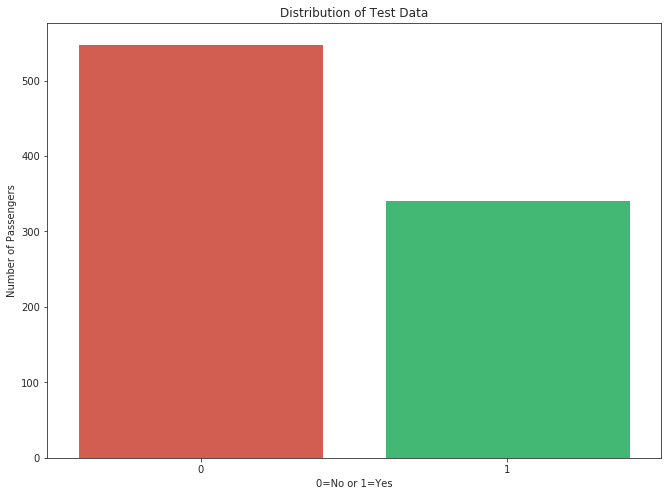

In [275]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
clrs = ['#e74c3c', '#2ecc71']
fig = sns.barplot(x=target_value_counts.index,
            y=target_value_counts, 
            capsize=.3, 
            palette=clrs)
plt.xlabel('0=No or 1=Yes')
plt.ylabel('Number of Passengers')
plt.title('Distribution of Test Data')
plt.show(fig)

## Exploratory Data Analysis
### Survival By Passenger Fare

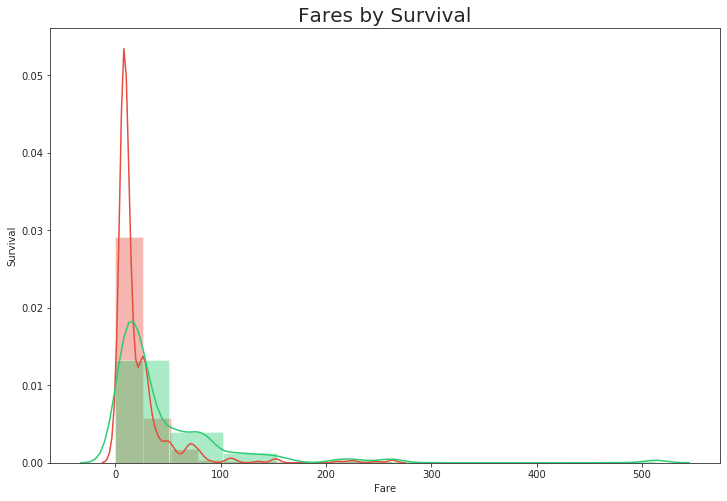

In [276]:
plt.figure(figsize=(12,8))

sns.distplot(train_data[train_data.Survived == 0]['Fare'], 
             bins=10, color='#e74c3c')
sns.distplot(train_data[train_data.Survived == 1]['Fare'], 
             bins=10, color='#2ecc71')
plt.title('Fares by Survival', fontsize=20)
plt.xlabel('Fare')
plt.ylabel('Survival')
plt.show()

### Survival by Passenger Sex 

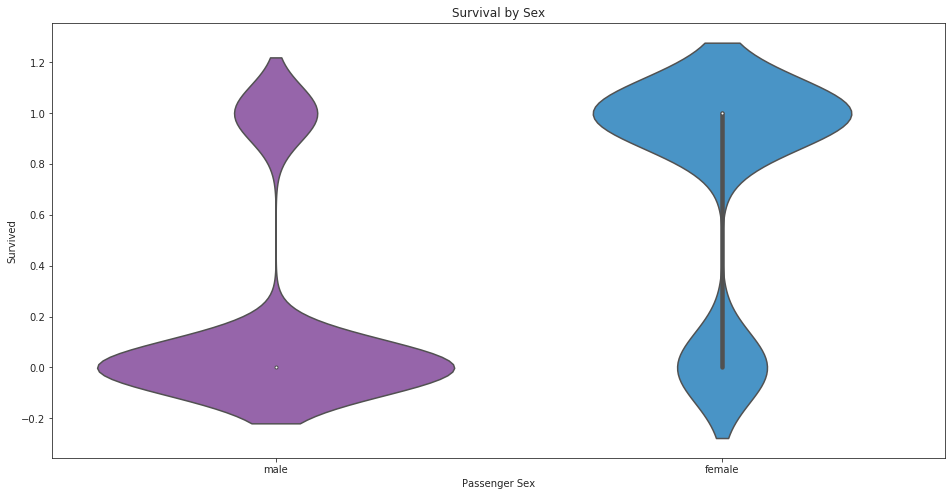

In [277]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="Sex",
            y="Survived",
            data=train_data)
plt.xlabel('Passenger Sex')
plt.ylabel('Survived')
plt.title('Survival by Sex')
plt.show(fig)

### Survival by Pclass

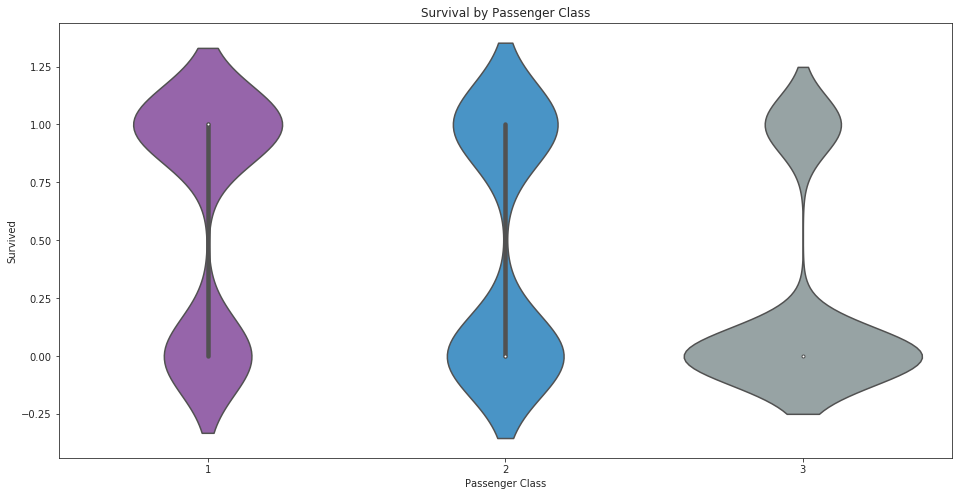

In [278]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="Pclass",
            y="Survived",
            data=train_data)
plt.xlabel('Passenger Class')
plt.title('Survival by Passenger Class')
plt.show(fig)

## Feature Engineering
### Title Feature

#### Create Title Feature

In [279]:
train_data['Title'] = train_data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

title_dict = {
        'Capt': 'Officer',
        'Col':  'Officer',
        'Major': 'Officer',
        'Dr': 'Professional',
        'Rev': 'Professional',
        'Jonkheer': 'Elite',
        'Don': 'Elite',
        'Sir' : 'Elite',
        'the Countess':'Elite',
        'Dona': 'Elite',
        'Lady' : 'Elite',
        'Mme': 'Elite',
        "Ms": 'Mrs',
        "Mrs" : 'Mrs',
        "Mlle": 'Miss',
        "Miss" : 'Miss',
        "Mr" :  'Mr',
        "Master" : 'Master'
    }

train_data['Title'] = train_data.Title.map(title_dict)
train_data['Title'] = train_data.Title.fillna('Unknown')

#### Distribution of Titles

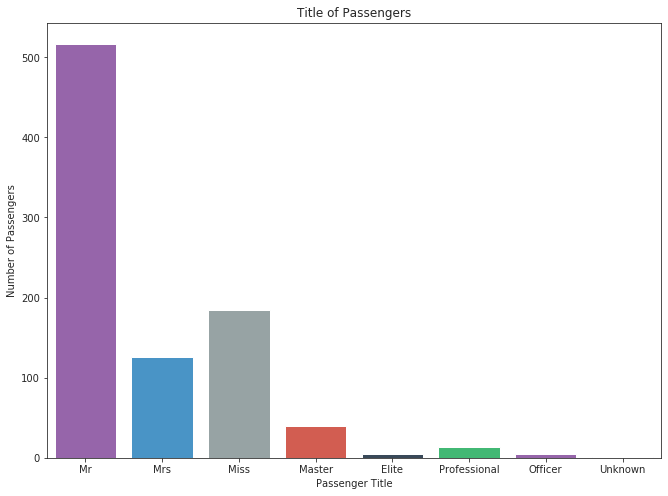

In [280]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
fig = sns.countplot(x='Title', 
            capsize=.3, 
            palette=flatui,
            data=train_data)
plt.xlabel('Passenger Title')
plt.ylabel('Number of Passengers')
plt.title('Title of Passengers')
plt.show(fig)

#### Survival by Title

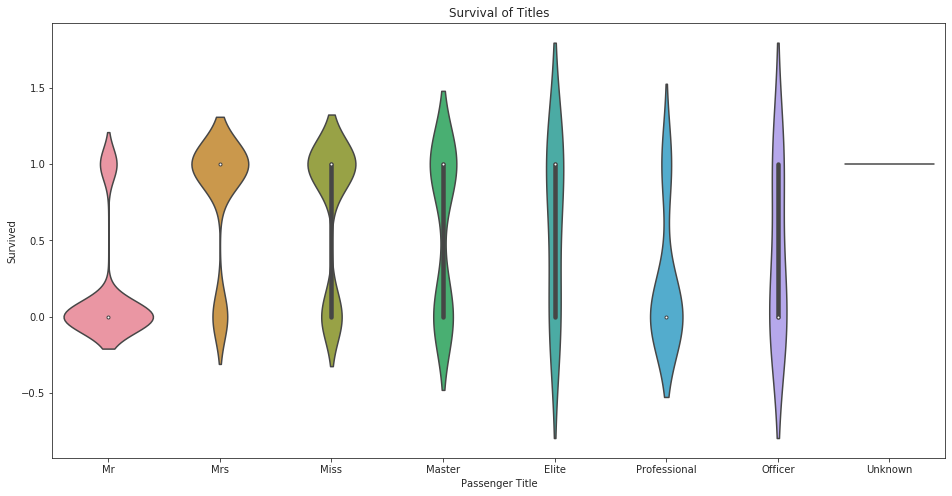

In [281]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="Title",
            y="Survived",
            data=train_data)
plt.xlabel('Passenger Title')
plt.ylabel('Survived')
plt.title('Survival of Titles')
plt.show(fig)

### Family Size

#### Create a Family Size Feature

In [282]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

#### Distribution of Family Size

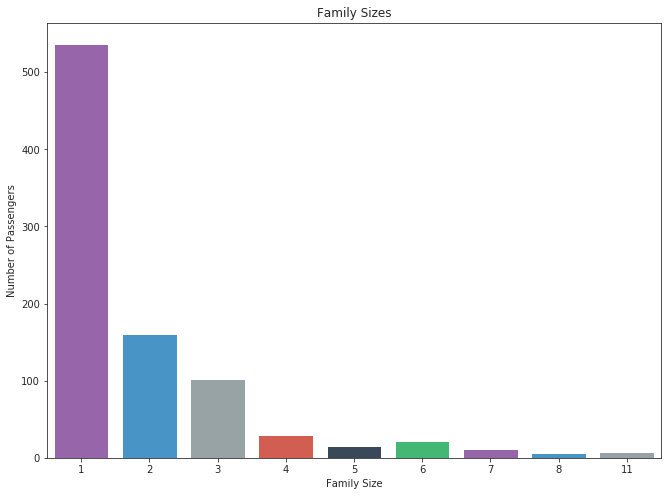

In [283]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.countplot(x='FamilySize',
            capsize=.3, 
            palette=flatui,
            data=train_data)
plt.xlabel('Family Size')
plt.ylabel('Number of Passengers')
plt.title('Family Sizes')
plt.show(fig)

#### Survival By Family Size

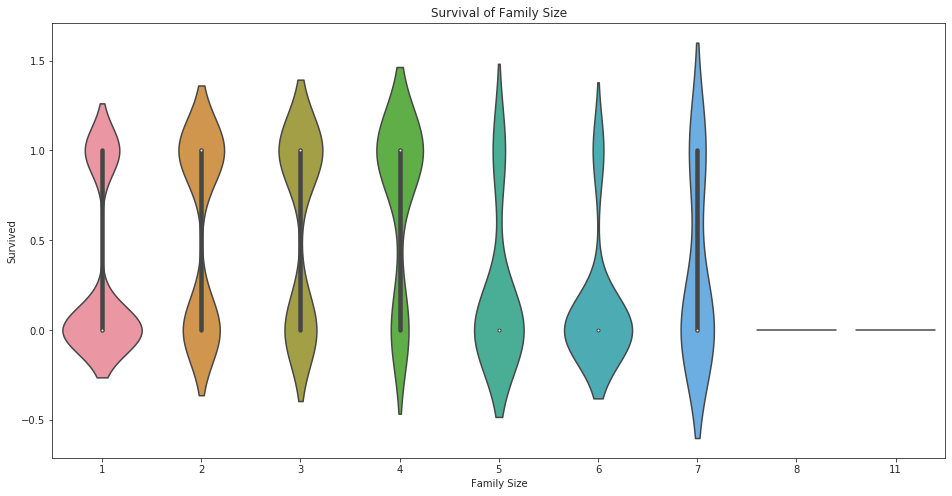

In [284]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="FamilySize",
            y="Survived",
            data=train_data)
plt.xlabel('Family Size')
plt.ylabel('Survived')
plt.title('Survival of Family Size')
plt.show(fig)

### Fare Feature
#### Create Fare Category

In [285]:
#Filling missing fares
train_data.Fare = train_data.Fare.fillna(-0.1)

fare_intervals = (-1, 0, 8, 15, 31, 600)
fare_labels = ['None', 'Group1', 'Group2', 'Group3', 'Group4']
train_data["FareCat"] = pd.cut(train_data.Fare, fare_intervals, labels=fare_labels)

#### Fare Category Distribution

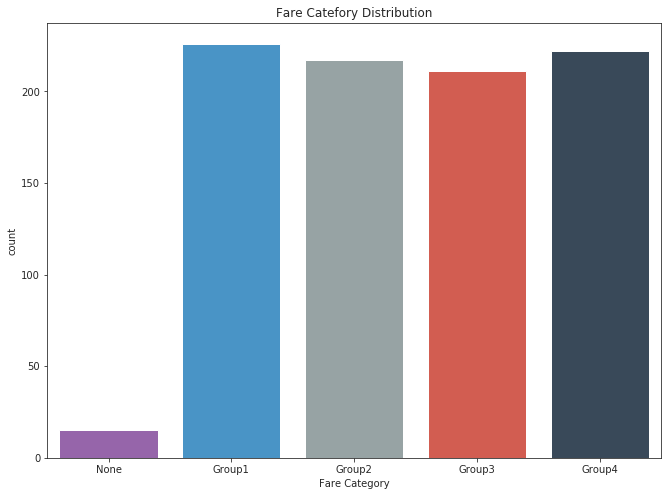

In [286]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.countplot(x='FareCat',
            capsize=.3, 
            palette=flatui,
            data=train_data)
plt.xlabel('Fare Category')
plt.title('Fare Catefory Distribution')
plt.show(fig)

#### Survival by Fare Category

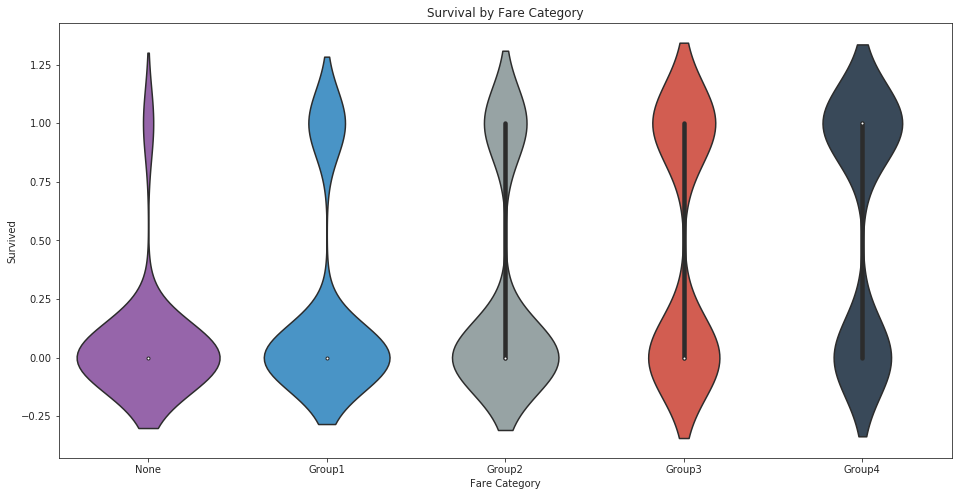

In [287]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="FareCat",
            y="Survived",
            data=train_data)
plt.xlabel('Fare Category')
plt.title('Survival by Fare Category')
plt.show(fig)

### Age Feature

In [288]:
# Impute missing ages by sex, class, and title.
train_data.loc[train_data.Age.isnull(), 'Age'] = train_data.groupby(['Sex','Pclass','Title']).Age.transform('median')
print('Null count: {}'.format(train_data['Age'].isnull().sum()))

Null count: 0


#### Age Distributuion Density

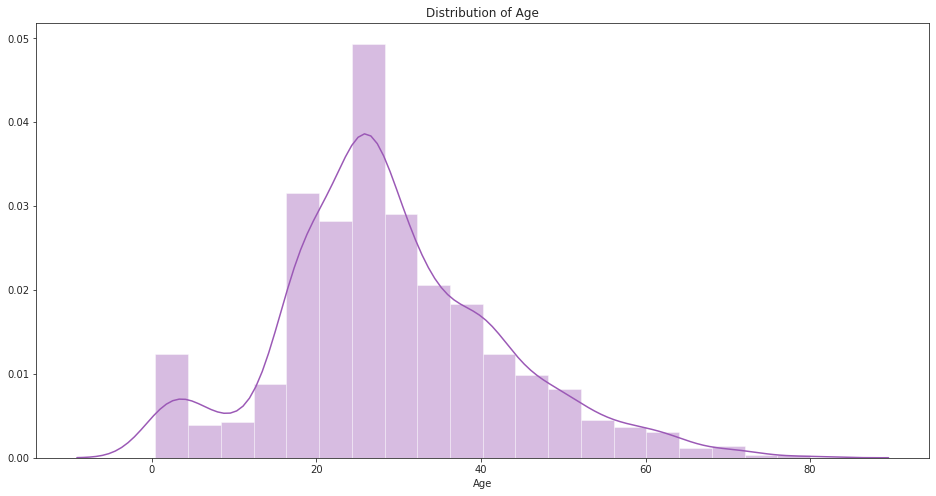

In [289]:
sns.set_style('ticks')
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.distplot(train_data['Age'],
            bins=20)
plt.xlabel('Age')
plt.title('Distribution of Age')
plt.show(fig)

#### Age Density by Survival

<Figure size 1152x576 with 0 Axes>

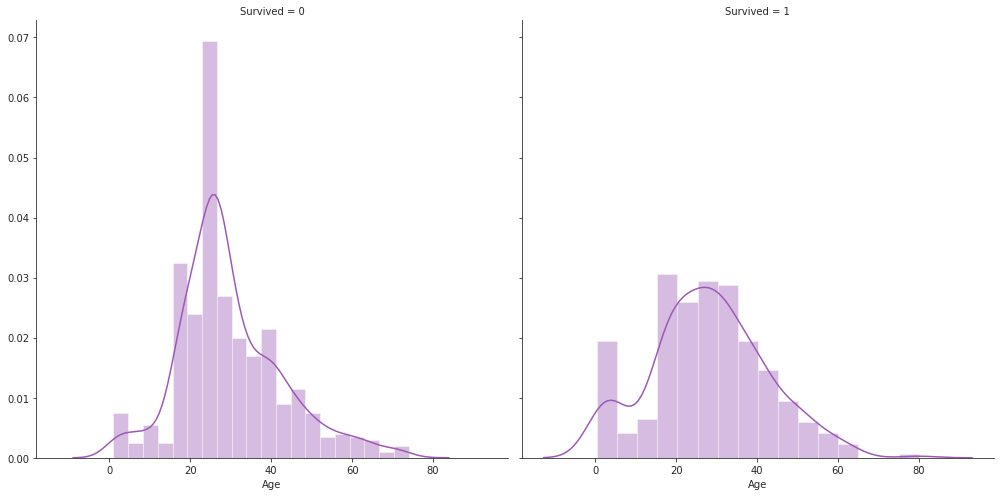

In [290]:
plt.figure(figsize=(16,8))
g = sns.FacetGrid(train_data, col='Survived',size=7)
g = g.map(sns.distplot, "Age")
plt.show()

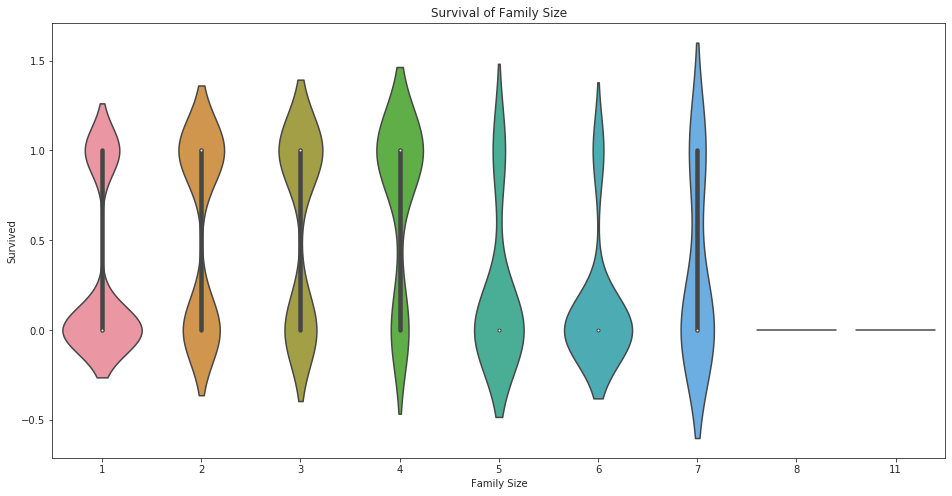

In [291]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="FamilySize",
            y="Survived",
            data=train_data)
plt.xlabel('Family Size')
plt.ylabel('Survived')
plt.title('Survival of Family Size')
plt.show(fig)

#### Bin The Ages

In [292]:
train_data['AgeGroup'] = None
train_data.loc[((train_data['Sex'] == 'male') & (train_data['Age'] <= 15)), 'AgeGroup'] = 'Boy'
train_data.loc[((train_data['Sex'] == 'female') & (train_data['Age'] <= 15)), 'AgeGroup'] = 'Girl'
train_data.loc[((train_data['Sex'] == 'male') & (train_data['Age'] > 15)), 'AgeGroup'] = 'AdultMale'
train_data.loc[((train_data['Sex'] == 'female') & (train_data['Age'] > 15)), 'AgeGroup'] = 'AdultFemale'

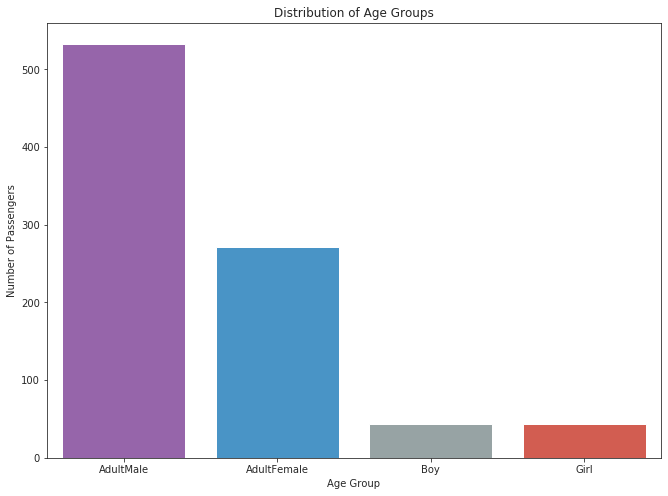

In [293]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.countplot(x='AgeGroup',
            capsize=.3, 
            palette=flatui,
            data=train_data)
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.title('Distribution of Age Groups')
plt.show(fig)

#### Survival Rate for Age Groups

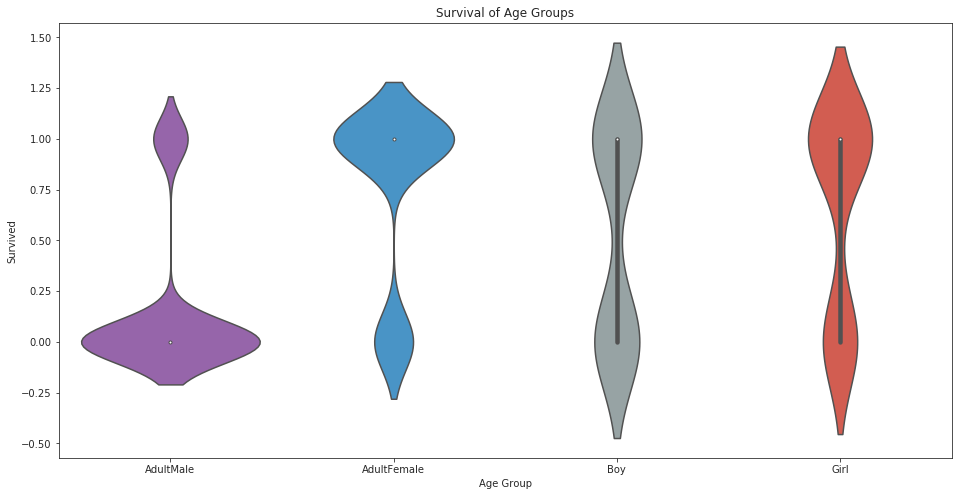

In [294]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="AgeGroup",
            y="Survived",
            data=train_data)
plt.xlabel('Age Group')
plt.ylabel('Survived')
plt.title('Survival of Age Groups')
plt.show(fig)

### Cabin Feature
#### Create Deck Feature

In [295]:
train_data['Deck'] = train_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# Passengers in T deck changed to A deck
idx = train_data[train_data['Deck'] == 'T'].index
train_data.loc[idx, 'Deck'] = 'A'

# Group decks
train_data['Deck'] = train_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
train_data['Deck'] = train_data['Deck'].replace(['D', 'E'], 'DE')
train_data['Deck'] = train_data['Deck'].replace(['F', 'G'], 'FG')

#### Passenger Distribution by Deck

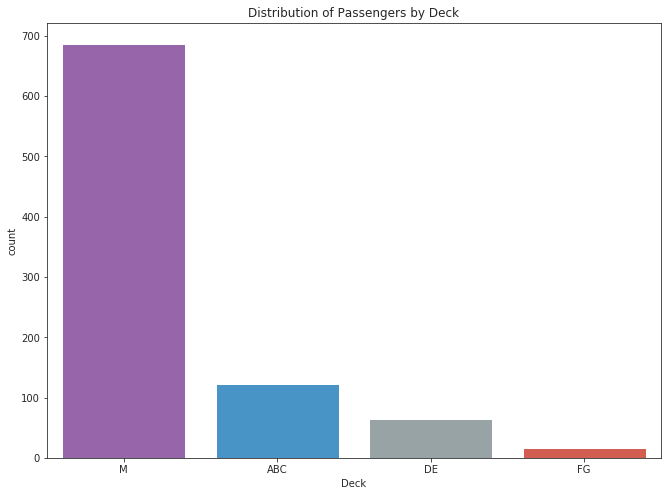

In [296]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.countplot(x='Deck',
            capsize=.3, 
            palette=flatui,
            data=train_data)
plt.xlabel('Deck')
plt.title('Distribution of Passengers by Deck')
plt.show(fig)

#### Survival by Deck

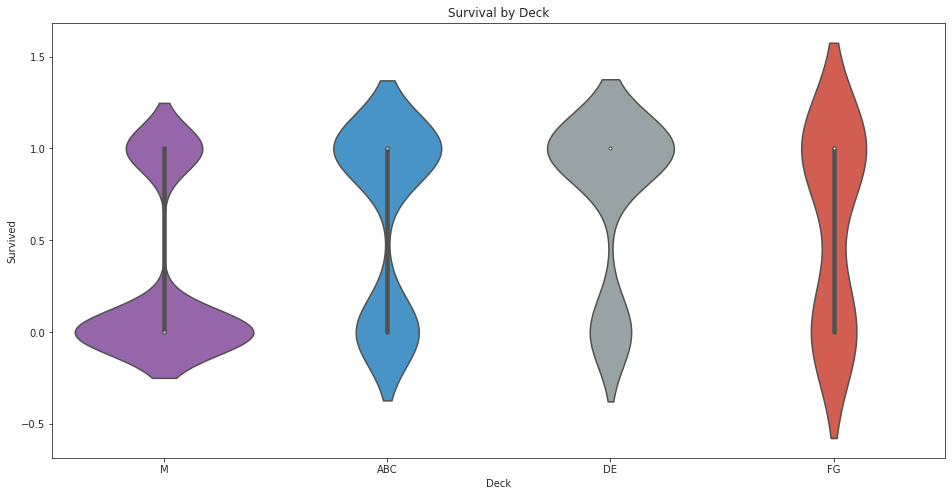

In [297]:
fig, ax  = plt.subplots()
fig.set_size_inches(16, 8)
fig = sns.violinplot(x="Deck",
            y="Survived",
            data=train_data)
plt.xlabel('Deck')
plt.title('Survival by Deck')
plt.show(fig)

## Preprocessing

### Feature Engineering Method

In [298]:
# Revert to clean copy
train_data = clean_copy.copy()

In [299]:
def get_title(name):
    title_search = re.search(r'([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

In [300]:
def replace_titles(title):
    if title in ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Rare'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [301]:
train_data['Parch'].value_counts()
test_data['Parch'].value_counts()

0    324
1     52
2     33
3      3
9      2
4      2
6      1
5      1
Name: Parch, dtype: int64

In [302]:
def feature_eng(X):
    # Rename Categorical Columns
    
    # Create title feature
    X['Title'] = X['Name'].apply(get_title)
    X['Title'] = X['Title'].fillna('Miss')
    X['Title'] = X['Title'].apply(replace_titles)
    
    # Drop Name
    X.drop('Name', axis=1, inplace=True)
    
    #Impute Age
    X.loc[X.Age.isnull(), 'Age'] = X.groupby(['Sex','Pclass','Title']).Age.transform('median')
    
    # Convert Pclass
    X['Pclass'] = X['Pclass'].apply(lambda x: 'first' if x==1 else 'second' if x==2 else 'third')
    
    # Create Age Bins
    binner = KBinsDiscretizer(encode='ordinal')
    binner.fit(X[['Age']])
    X['AgeBins'] = binner.transform(X[['Age']])
    
    # Create family size feature
    X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
    
    # Family size mapping
    family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 
                  5: 'Large', 6: 'Large', 7: 'Large', 8: 'Large', 11: 'Large'}
    X['GroupSize'] = X['FamilySize'].map(family_map)
    
    # With Family Feature
    X['WithFamily'] = (X['FamilySize']>1)
    X['WithFamily'] = X['WithFamily'].apply(lambda x: 'yes' if x==1 else 'no')
    
    # Impute Fares
    X.loc[(X.Fare.isnull()), 'Fare'] = X.Fare.median()
    X.loc[(X.Fare==0), 'Fare'] = X.Fare.median()
    
    # Create Fare Bins
    binner.fit(X[['Fare']])
    X['FareBins'] = binner.transform(X[['Fare']])
    
    # Create deck and room features
    X["Deck"] = X["Cabin"].str.slice(0,1)
    X["Deck"] = X["Deck"].fillna("N")
    idx = X[X['Deck'] == 'T'].index
    X.loc[idx, 'Deck'] = 'A'
    
    X["Room"] = X["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False)
    X['Room'] = X['Room'].astype(str)
    X["Room"] = X["Room"].fillna('None')
    
    # Drop Cabin
    X.drop('Cabin', axis=1, inplace=True)
    
    # Impute Embarked
    encoder=OrdinalEncoder()
    X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

    # Add some log features
    X['LogAge'] = np.log(X['Age'])
    X['LogFare'] = np.log(X['Fare'])
    X['LogFamilySize'] = np.log(X['Fare'])
    
    # Add scaled features
    scaler = StandardScaler()
    scaler.fit(X[['Age']])
    X['AgeScaled'] = scaler.transform(X[['Age']])
    
    scaler.fit(X[['Fare']])
    X['FareScaled'] = scaler.transform(X[['Fare']])
    
    scaler.fit(X[['FamilySize']])
    X['FareScaled'] = scaler.transform(X[['Fare']])
    
    # Get Dummies
    X = pd.get_dummies(X, prefix='dummy', drop_first=True)
    X.drop('PassengerId', axis=1, inplace=True)
    X.drop('Age', axis=1, inplace=True)
    X.drop('Parch', axis=1, inplace=True)
    X.drop('SibSp', axis=1, inplace=True)
    X.drop('Fare', axis=1, inplace=True)
    return X

In [303]:
# Test feature eng method
train_data_proc = feature_eng(train_data)
train_data_proc.head()

,Survived,AgeBins,FamilySize,FareBins,LogAge,LogFare,LogFamilySize,AgeScaled,FareScaled,dummy_second,...,dummy_9,dummy_90,dummy_91,dummy_92,dummy_93,dummy_94,dummy_95,dummy_96,dummy_99,dummy_nan
0,0,1.0,2,0.0,3.091042,1.981001,1.981001,-0.529214,3.314867,0,...,0,0,0,0,0,0,0,0,0,1
1,1,3.0,2,4.0,3.637586,4.266662,4.266662,0.657366,43.024139,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2.0,1,1.0,3.258097,2.070022,2.070022,-0.232569,3.733458,0,...,0,0,0,0,0,0,0,0,0,1
3,1,3.0,2,4.0,3.555348,3.972177,3.972177,0.434882,31.748043,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3.0,1,1.0,3.555348,2.085672,2.085672,0.434882,3.810975,0,...,0,0,0,0,0,0,0,0,0,1


### Train-Validation Split

In [304]:
# Constants
SEED = 37
TRAIN_SPLIT = .15

scores = ['precision', 'recall']

train_data = clean_copy.copy()

# Split off some testing data
strat_split = StratifiedShuffleSplit(n_splits=1,
                              test_size=TRAIN_SPLIT,
                              random_state=SEED)

for train_index, val_index in strat_split.split(train_data,  train_data[['Sex', 'Pclass']]): 
    X_train = train_data.loc[train_index]
    X_val = train_data.loc[val_index]
    
X_test = test_data.copy()    
    
y_train = X_train['Survived'].copy()
y_val = X_val['Survived'].copy()
X_train.drop('Survived', axis=1, inplace=True)
X_val.drop('Survived', axis=1, inplace=True)
    
print('X_train shape: {}'.format(X_train.shape))
print('X_val shape: {}'.format(X_val.shape))

print('{} training records'.format(len(X_train)))
print('{} training labels'.format(len(y_train)))
  
print('{} validation records'.format(len(X_val)))
print('{} validation labels'.format(len(y_val)))

X_train['dataset'] = 1
X_val['dataset'] = 2
X_test['dataset'] = 3

combined = pd.concat([X_train, X_val, X_test])
combined.reset_index(drop=True, inplace=True)

# call feature engineering method
X_eng = feature_eng(combined)

print('combined shape: {}'.format(X_eng.shape))

X_train_eng = X_eng[X_eng['dataset'] == 1]
X_val_eng = X_eng[X_eng['dataset'] == 2]
X_test_eng = X_eng[X_eng['dataset'] == 3]
X_train_eng.drop('dataset', axis=1, inplace=True)
X_val_eng.drop('dataset', axis=1, inplace=True)
X_test_eng.drop('dataset', axis=1, inplace=True)
X_train_eng.head()

X_train shape: (757, 11)
X_val shape: (134, 11)
757 training records
757 training labels
134 validation records
134 validation labels
combined shape: (1309, 1060)


,AgeBins,FamilySize,FareBins,LogAge,LogFare,LogFamilySize,AgeScaled,FareScaled,dummy_second,dummy_third,...,dummy_90,dummy_91,dummy_92,dummy_93,dummy_94,dummy_95,dummy_96,dummy_97,dummy_99,dummy_nan
0,4.0,1,2.0,3.737670,2.564949,2.564949,0.947270,7.022034,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,5,3.0,2.890372,3.237372,3.237372,-0.838171,14.897228,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.0,1,1.0,2.833213,2.159003,2.159003,-0.912565,4.282043,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4.0,1,4.0,4.262680,3.902058,3.902058,3.104678,30.081677,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,6,2.0,3.178054,2.931194,2.931194,-0.391811,10.654300,1,0,...,0,0,0,0,0,0,0,0,0,1


## Build and Evaluate a Random Forest Classifier

In [305]:
rf_params = [{'n_estimators': [100, 150, 200]}]

for score in scores:
    print('Tuning hyper-parameters for %s \n' % score)
    print ('Creating pipeline instance.')
    train_pipeline = Pipeline([
          ('classifier', GridSearchCV(RandomForestClassifier(random_state=SEED),
                                    rf_params, 
                                    scoring='%s_macro' % score,
                                    verbose=10,
                                    n_jobs=-1,
                                    cv=8))])
    
    print('Fitting the model.')
    train_pipeline.fit(X_train_eng, y_train)

    print('Tuning hyper-parameters for %s \n' % score)
    print('Best parameters set found on development set: \n')
    print(train_pipeline.named_steps['classifier'].best_params_, '\n')
    print("Grid scores on development set:\n")
    means = train_pipeline.named_steps['classifier'].cv_results_['mean_test_score']
    stds = train_pipeline.named_steps['classifier'].cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, train_pipeline.named_steps['classifier'].cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print()
    print('Detailed classification report:\n')
    print('The model is trained on the full development set.')
    print('The scores are computed on the full evaluation set.\n')
    y_true, y_pred = y_val, train_pipeline.predict(X_val_eng)
    print(classification_report(y_val, y_pred), '\n')

Tuning hyper-parameters for precision 

Creating pipeline instance.
Fitting the model.
Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    2.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.9s finished


Tuning hyper-parameters for precision 

Best parameters set found on development set: 

{'n_estimators': 150} 

Grid scores on development set:

0.809 (+/-0.091) for {'n_estimators': 100}
0.822 (+/-0.108) for {'n_estimators': 150}
0.819 (+/-0.096) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        80
           1       0.91      0.78      0.84        54

    accuracy                           0.88       134
   macro avg       0.89      0.86      0.87       134
weighted avg       0.88      0.88      0.88       134
 

Tuning hyper-parameters for recall 

Creating pipeline instance.
Fitting the model.
Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    2.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.8s finished


Tuning hyper-parameters for recall 

Best parameters set found on development set: 

{'n_estimators': 200} 

Grid scores on development set:

0.788 (+/-0.086) for {'n_estimators': 100}
0.801 (+/-0.106) for {'n_estimators': 150}
0.801 (+/-0.095) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        80
           1       0.91      0.78      0.84        54

    accuracy                           0.88       134
   macro avg       0.89      0.86      0.87       134
weighted avg       0.88      0.88      0.88       134
 



### Random Forest Classifier Confusion Matrix

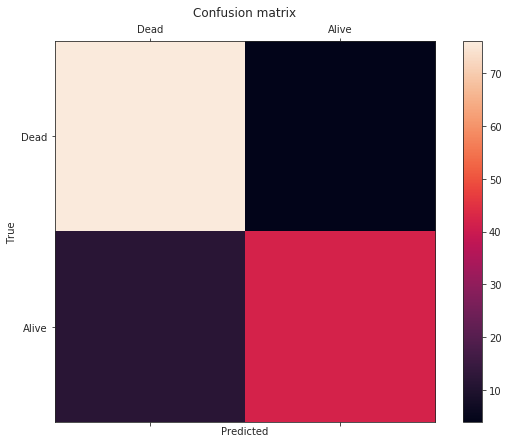

In [306]:
cm = confusion_matrix(y_val, y_pred)
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
labels = ['Dead', 'Alive']
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Build and Evaluate a Logistic Regression Classifier

In [307]:
lr_params = [{'C': [1, 3, 5]}]

for score in scores:
    print('Tuning hyper-parameters for %s \n' % score)
    print ('Creating pipeline instance.')
    train_pipeline = Pipeline([
          ('classifier', GridSearchCV(LogisticRegression(random_state=SEED),
                                    lr_params, 
                                    scoring='%s_macro' % score,
                                    verbose=10,
                                    n_jobs=-1,
                                    cv=8))])
    
    print('Fitting the model.')
    train_pipeline.fit(X_train_eng, y_train)

    print('Tuning hyper-parameters for %s \n' % score)
    print('Best parameters set found on development set: \n')
    print(train_pipeline.named_steps['classifier'].best_params_, '\n')
    print("Grid scores on development set:\n")
    means = train_pipeline.named_steps['classifier'].cv_results_['mean_test_score']
    stds = train_pipeline.named_steps['classifier'].cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, train_pipeline.named_steps['classifier'].cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print()
    print('Detailed classification report:\n')
    print('The model is trained on the full development set.')
    print('The scores are computed on the full evaluation set.\n')
    y_true, y_pred = y_val, train_pipeline.predict(X_val_eng)
    print(classification_report(y_val, y_pred), '\n')

Tuning hyper-parameters for precision 

Creating pipeline instance.
Fitting the model.
Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Tuning hyper-parameters for precision 

Best parameters set found on development set: 

{'C': 3} 

Grid scores on development set:

0.811 (+/-0.089) for {'C': 1}
0.818 (+/-0.066) for {'C': 3}
0.811 (+/-0.068) for {'C': 5}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.90      0.89      0.89        80
           1       0.84      0.85      0.84        54

    accuracy                           0.87       134
   macro avg       0.87      0.87      0.87       134
weighted avg       0.87      0.87      0.87       134
 

Tuning hyper-parameters for recall 

Creating pipeline instance.
Fitting the model.
Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1609s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.8s finished


Tuning hyper-parameters for recall 

Best parameters set found on development set: 

{'C': 3} 

Grid scores on development set:

0.803 (+/-0.100) for {'C': 1}
0.817 (+/-0.081) for {'C': 3}
0.812 (+/-0.077) for {'C': 5}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.90      0.89      0.89        80
           1       0.84      0.85      0.84        54

    accuracy                           0.87       134
   macro avg       0.87      0.87      0.87       134
weighted avg       0.87      0.87      0.87       134
 



### Logistic Regression Confusion Matrix

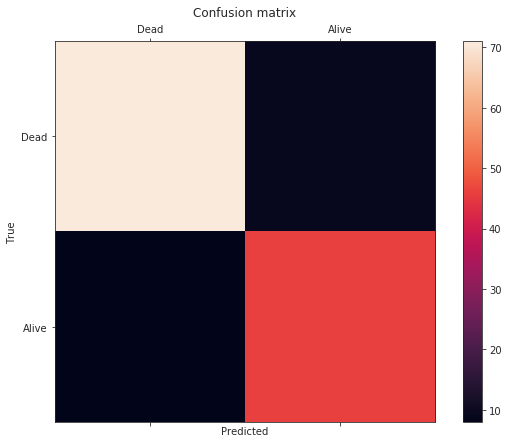

In [308]:
cm = confusion_matrix(y_val, y_pred)
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
labels = ['Dead', 'Alive']
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Build and Evaluate an LinearSVC Classifier

In [309]:
svc_params = [{'C': [1,3,5]}]

for score in scores:
    print('Tuning hyper-parameters for %s \n' % score)
    print ('Creating pipeline instance.')
    train_pipeline = Pipeline([
          ('classifier', GridSearchCV(SVC(random_state=SEED),
                                    svc_params, 
                                    scoring='%s_macro' % score,
                                    verbose=10,
                                    n_jobs=-1,
                                    cv=8))])
    
    print('Fitting the model.')
    train_pipeline.fit(X_train_eng, y_train)

    print('Tuning hyper-parameters for %s \n' % score)
    print('Best parameters set found on development set: \n')
    print(train_pipeline.named_steps['classifier'].best_params_, '\n')
    print("Grid scores on development set:\n")
    means = train_pipeline.named_steps['classifier'].cv_results_['mean_test_score']
    stds = train_pipeline.named_steps['classifier'].cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, train_pipeline.named_steps['classifier'].cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print()
    print('Detailed classification report:\n')
    print('The model is trained on the full development set.')
    print('The scores are computed on the full evaluation set.\n')
    y_true, y_pred = y_val, train_pipeline.predict(X_val_eng)
    print(classification_report(y_val, y_pred), '\n')

Tuning hyper-parameters for precision 

Creating pipeline instance.
Fitting the model.
Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    1.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.8s finished


Tuning hyper-parameters for precision 

Best parameters set found on development set: 

{'C': 5} 

Grid scores on development set:

0.704 (+/-0.121) for {'C': 1}
0.726 (+/-0.103) for {'C': 3}
0.766 (+/-0.133) for {'C': 5}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.81      0.70      0.75        54

    accuracy                           0.81       134
   macro avg       0.81      0.80      0.80       134
weighted avg       0.81      0.81      0.81       134
 

Tuning hyper-parameters for recall 

Creating pipeline instance.
Fitting the model.
Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.8s finished


Tuning hyper-parameters for recall 

Best parameters set found on development set: 

{'C': 5} 

Grid scores on development set:

0.620 (+/-0.045) for {'C': 1}
0.644 (+/-0.047) for {'C': 3}
0.726 (+/-0.108) for {'C': 5}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.81      0.70      0.75        54

    accuracy                           0.81       134
   macro avg       0.81      0.80      0.80       134
weighted avg       0.81      0.81      0.81       134
 



### LinearSVC Confusion Matrix

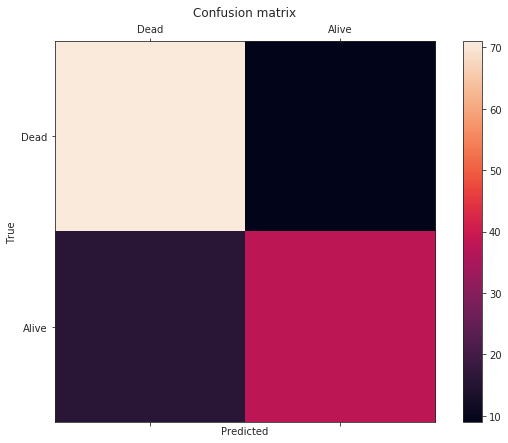

In [310]:
cm = confusion_matrix(y_val, y_pred)
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
labels = ['Dead', 'Alive']
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Ensemble, Retrain and Predict

### Retrain on Entire Test Set

In [311]:
train_data = pd.concat([X_train_eng, X_val_eng])
y_train = pd.concat([y_train, y_val])

voting_clf = VotingClassifier(
                             estimators=[
                                 ('rf', RandomForestClassifier(random_state=SEED,
                                                              n_estimators=150)),
                                 ('lr', LogisticRegression(random_state=SEED,
                                                          C=3)),
                                 ('svc', SVC(random_state=SEED,
                                                  C=3,
                                                  probability=True))
                             ],
                             voting='soft')
voting_clf.fit(train_data, y_train)

y_pred_test = voting_clf.predict(X_test_eng)
test_ids = test_data['PassengerId'].copy()

final_preds = pd.concat([test_ids, pd.Series(y_pred_test)], axis=1)


#### Save Predictions and Trained Model

In [312]:
# Save final predicions
csv_buffer = StringIO()
final_preds.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(MODEL_BUCKET, 'v1/prediction/finl_preds.csv').put(Body=csv_buffer.getvalue())

# Save trained model
s3_resource = boto3.resource('s3')
trained_model = pickle.dumps(voting_clf)
s3_resource.Object(MODEL_BUCKET, 'v1/model/trained_model.pickle').put(Body=trained_model)

{'ResponseMetadata': {'RequestId': 'EF5BB2910B190DE8',
  'HostId': 'WW+YJY8KNr6Qek7uycOujPtTyTwKAJOd4x8PRlLkiRLWasgoPKtFjWLc1z/olwwqXRPG31MeLYA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'WW+YJY8KNr6Qek7uycOujPtTyTwKAJOd4x8PRlLkiRLWasgoPKtFjWLc1z/olwwqXRPG31MeLYA=',
   'x-amz-request-id': 'EF5BB2910B190DE8',
   'date': 'Fri, 24 Jul 2020 15:39:47 GMT',
   'etag': '"8441ff9732404f1a31fdc1e7adf99ef4"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"8441ff9732404f1a31fdc1e7adf99ef4"'}